# A Non-Linear Latent Force Model
## Migratory Predator-Prey: Lotka-Volterra System with Quasi-Periodic Input


Predator-prey equation, with latent prey population $f_1(t)$ and predator population $f_2(t)$, with some migratory pattern $u(t)$
$$
    \frac{\mathrm{d}}{\mathrm{d}t}f_1(t) = \alpha(1+u(t))f_1(t) - \beta f_1(t)f_2(t)
$$
$$
    \frac{\mathrm{d}}{\mathrm{d}t}f_2(t) = \beta\delta f_1(t)f_2(t) + \gamma f_2(t)
$$
$$
    u(t) \sim \mathcal{GP}(m_u(t), k_u(t,t'))
$$

Population is some observed model: $\mathbf{y}(t) = \max(\lfloor\mathbf{f}(t) + w(t)\rfloor,0)$, where $w(t)$ is a Gaussian white-noise process.

We'll assume $u(t)$ has a zero-mean, quasi-periodic GP prior.

In [78]:
using LinearAlgebra
using Statistics
using Distributions
using PyPlot

In [21]:
system_params = [:α :β :δ :γ]

default_values = [2.0 1.2 1.0 3.0]

1×4 Array{Float64,2}:
 2.0  1.2  1.0  3.0

In [761]:
function lotka_volterra(f, θ, u::Union{Missing, Number}=missing)
    """ """
    ismissing(u) ? u = 0.0 : nothing;
    return [
        #θ[:α]*(1.0 + u)*f[1] - θ[:β]f[1]f[2],
        θ[:α]f[1] - θ[:β]f[1]f[2] + ((u == 0.0) ? θ[:σ]*u : u)
        θ[:β]θ[:δ]f[1]f[2] - θ[:γ]f[2]
    ]
end

function lotka_volterra!(df, f, θ, u::Union{Missing, Number}=missing)
    """ """
    df = lotka_volterra(f, θ, u)
end

lotka_volterra! (generic function with 2 methods)

In [80]:
f₀ = [1.,1.]
θ = Dict(system_params .=> default_values)

Dict{Symbol,Float64} with 4 entries:
  :α => 2.0
  :γ => 3.0
  :δ => 1.0
  :β => 1.2

In [654]:
function increment_rk4!(f, func::Function, Δ::AbstractFloat)
    k₁ = Δ*func(f)
    k₂ = Δ*func(f + 0.5k₁)
    k₃ = Δ*func(f + 0.5k₂)
    k₄ = Δ*func(f + k₃)
    
    f .+= k₁/6. + k₂/3. + k₃/3. + k₄/6.
end

function increment_rk4(f, func::Function, Δ::AbstractFloat)
    """ """
    tmp = copy(f);
    increment_rkf!(tmp, func, Δ);
    return tmp
end

increment_rk4 (generic function with 1 method)

In [98]:
t = range(0., stop=10., length=1000);

fs = zeros(2,length(t))
fs[:,1] = f₀
fₜ = copy(f₀);

for i ∈ 2:length(t)
    increment_rk4!(fₜ,f -> lotka_volterra(f, θ, 0.0), t[i]-t[i-1])
    fs[:,i] = fₜ
end

In [116]:
function solve_lv(f₀, t; display::Bool=false)
    """ Solve Lotka Volterra for zero net migration """
    fs = zeros(size(f₀,1), length(t));
    fs[:,1] = f₀
    fₜ = copy(f₀);

    for i ∈ 2:length(t)
        increment_rk4!(fₜ,f -> lotka_volterra(f, θ, 0.0), t[i]-t[i-1])
        fs[:,i] = fₜ
    end
    
    display ? [plot(t, fs[i,:]) for i ∈ 1:size(f₀,1)] : nothing;
    
    return fs
end

solve_lv (generic function with 1 method)

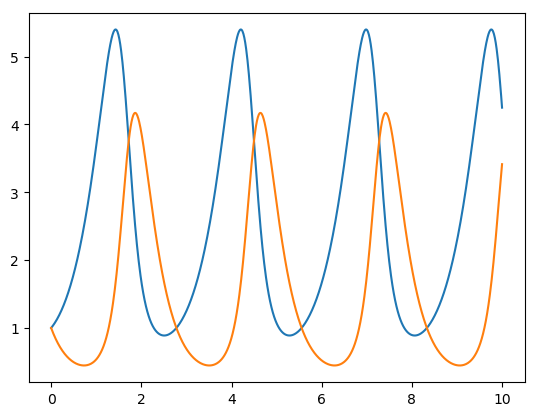

2×1000 Array{Float64,2}:
 1.0  1.00815   1.01658   1.02529   …  4.50665  4.42284  4.33665  4.24839
 1.0  0.982191  0.964795  0.947805     3.19126  3.26748  3.3421   3.41485

In [119]:
solve_lv(f₀, t, display=true)

In [632]:
include("SequentialGP.jl");

In [824]:
function solve_lfm_lv(f₀, t; display::Bool=false)
    """ Solve Lotka Volterra for with GP net migration """

    # kernel prior
    
    F, L, q, H = kern_seq_periodic(8, ω=4/2, v=20.);
    #F, L, q, H = kern_seq_matern(ν=7/2, l = 0.5);
    
    P₀ = cov_seq_steadystate(F, L, q);
    
    𝐷, 𝑁 = size(F, 1), length(f₀);
    
    A = exp(F * (t[2]-t[1]));
    Q = Hermitian(P₀ - A*P₀*A') |> Matrix; assertposdef!(Q);
    
    μ = rand(MvNormal(P₀));
    
    fs = zeros(size(H,1) + 𝑁, length(t));
    
    fˡ = [μ ; f₀]
    
    fs[:,1] = [H*μ ; f₀];
    
    fₜ = copy(fˡ)
    
    𝐇 = [H zeros(size(H,1), 𝑁) ; zeros(𝑁, size(H,2)) Matrix(I, 𝑁, 𝑁)]
    print(size(𝐇))
    for i ∈ 2:length(t)
        fₜ[1:𝐷] = A*fₜ[1:𝐷] + rand(MvNormal(Q));
        uᵛ = fₜ[𝐷+1:end]
        increment_rk4!(
            uᵛ,
            f -> lotka_volterra(f, θ, (H*fₜ[1:𝐷])[1]),
            t[i]-t[i-1]
        )
        fₜ[𝐷+1:end] = uᵛ;
        any(isnan.(fₜ)) ? (return fs[:,1:i-1]) : fs[:,i] = 𝐇 * fₜ
    end
    
    display ? [plot(t, fs[i,:]) for i ∈ (size(H,1)+1):size(fs,1)] : nothing;
    
    return fs
end

solve_lfm_lv (generic function with 1 method)

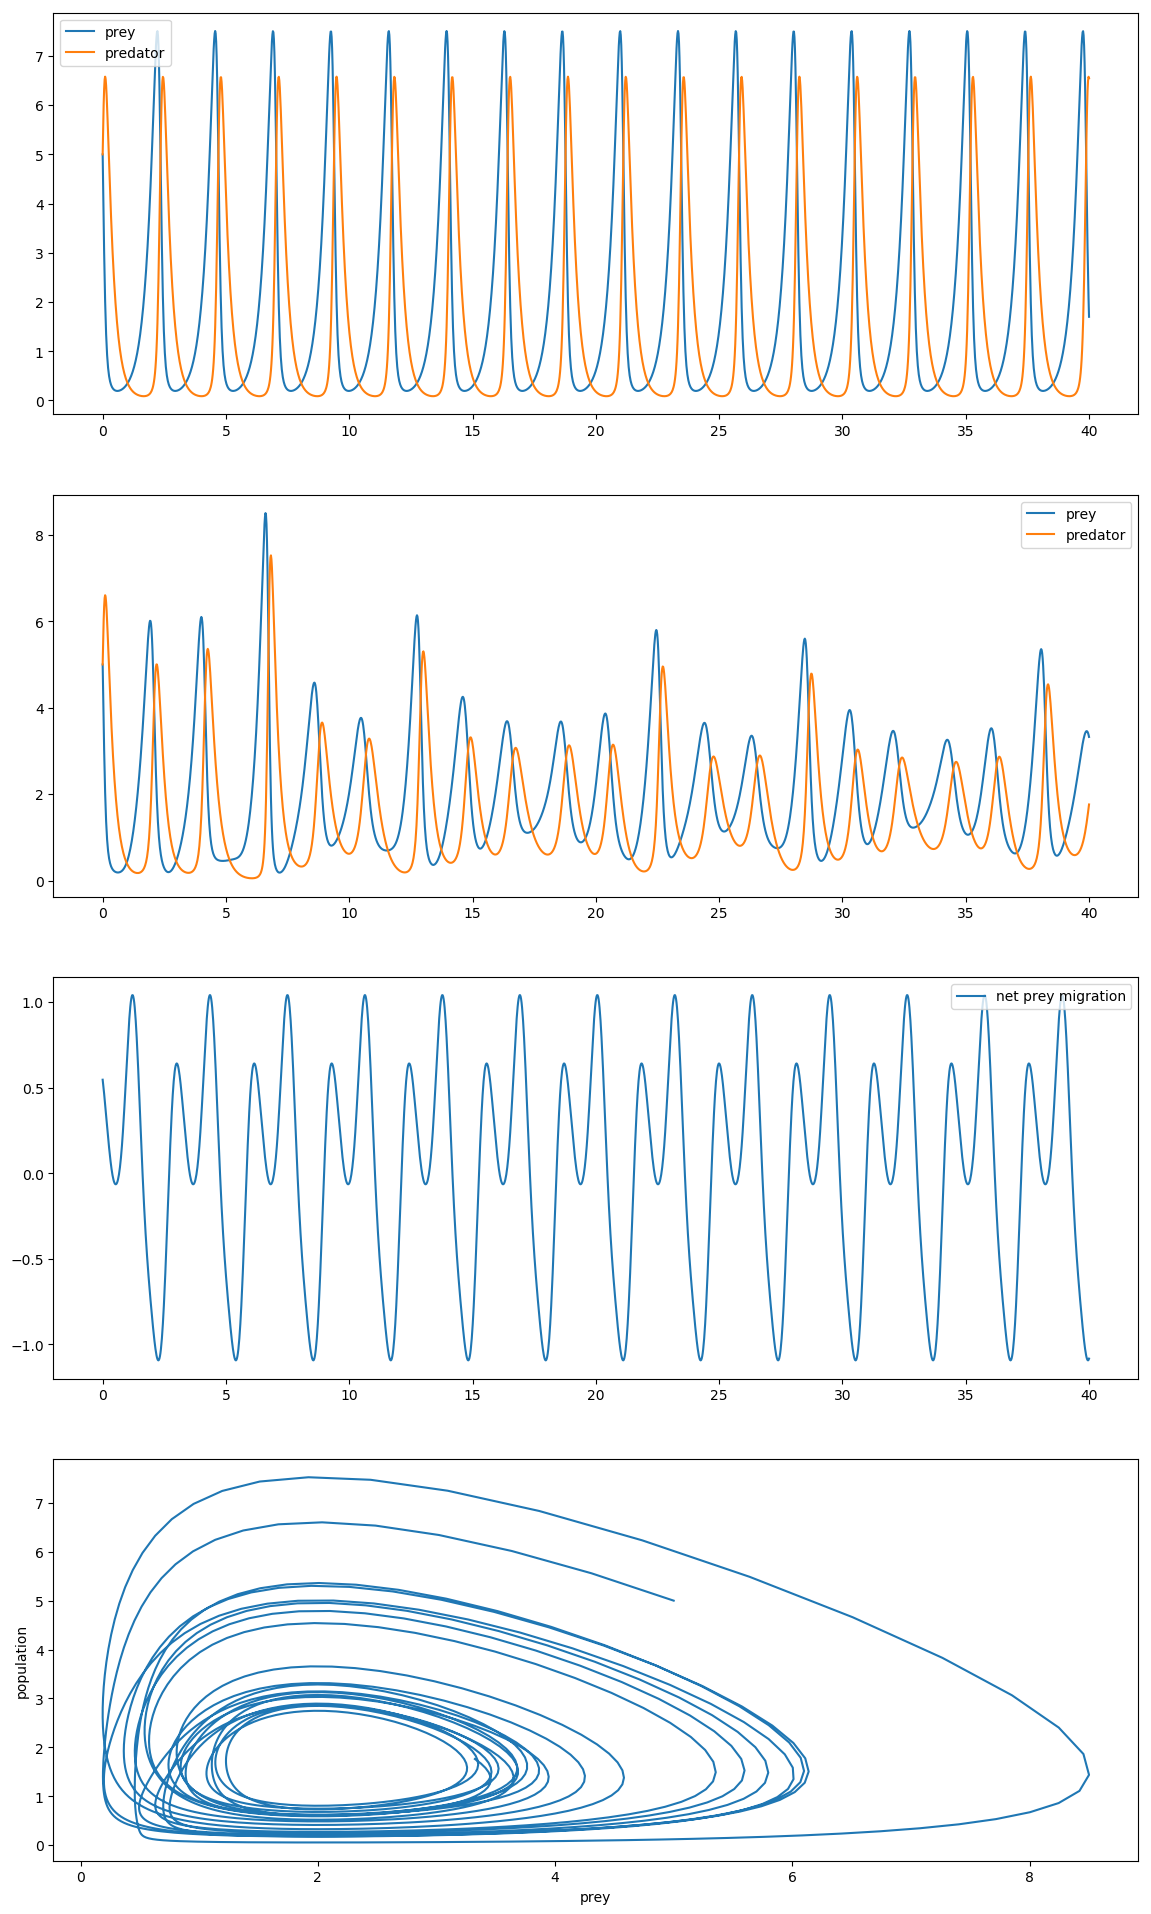

(3, 20)

In [825]:
t = range(0., stop=40., length=2000);

f₀ = [5.;5.]
    
θ = Dict(
    :α => 3.,
    :β => 2.,
    :δ => 1.,
    :γ => 4.,
    :σ => 1.
)

figure(figsize=(14,24))

subplot(411)
solve_lv(f₀, t, display=true);
legend(labels=["prey", "predator"])

subplot(412)
fs = solve_lfm_lv(f₀, t);
[plot(t, fs[i,:]) for i ∈ 2:3]
legend(labels=["prey", "predator"])

subplot(413)
plot(t,fs[1,:])
legend(labels=["net prey migration"])

subplot(414)
plot(fs[2,:], fs[3,:])
xlabel("prey"), ylabel("population")
; # supress output

3×160 Array{Float64,2}:
 1.52361  1.39839  1.27161  1.14387  1.01654  …   0.951178     1.01142    
 5.0      4.3226   3.66226  3.05499  2.52242      1.89624e20   1.23006e299
 5.0      5.56196  6.02282  6.35789  6.55995     -1.89624e20  -1.23006e299

In [750]:
using DelimitedFiles

open("model_lfmlv.txt","w") do io
    writedlm(io, fs', ',')
end